In [72]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
from yellowbrick.cluster import KElbowVisualizer # cluster visualizer

In [74]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder


In [75]:
df = pd.read_csv("housing.csv")

In [76]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [77]:
df_new = df.drop(["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value", "ocean_proximity"], axis=1)

In [78]:
df_target = df["median_house_value"]

Используем "метод локтя для поиска количества кластеров"

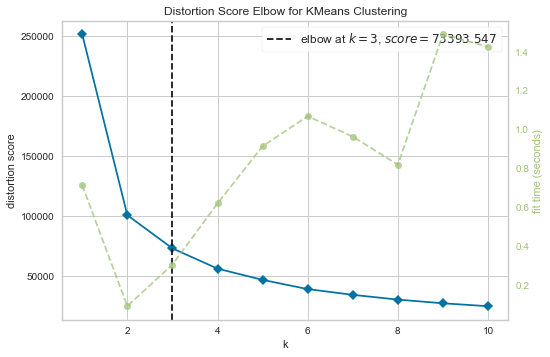

In [79]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(df_new) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show() 

Будем использовать широту, долготу и медианный доход в качестве фичей

In [80]:
km_model = KMeans(n_clusters=5, random_state=10)

# call fit method with data 
km = km_model.fit_predict(df_new)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

In [81]:
df_new["Cluster"] = km
df_new["Cluster"] = df_new["Cluster"].astype("category")

df_new.head()

,longitude,latitude,median_income,Cluster
0,-122.23,37.88,8.3252,2
1,-122.22,37.86,8.3014,2
2,-122.24,37.85,7.2574,2
3,-122.25,37.85,5.6431,2
4,-122.25,37.85,3.8462,0


In [82]:
df_new.head()

,longitude,latitude,median_income,Cluster
0,-122.23,37.88,8.3252,2
1,-122.22,37.86,8.3014,2
2,-122.24,37.85,7.2574,2
3,-122.25,37.85,5.6431,2
4,-122.25,37.85,3.8462,0


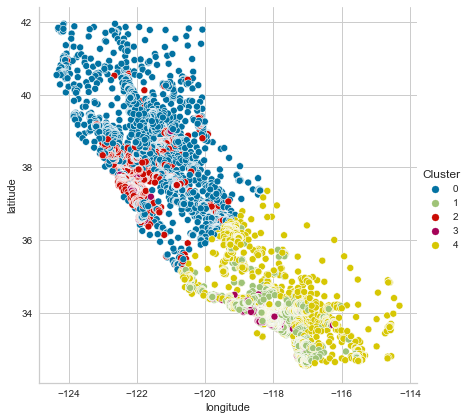

In [83]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=df_new, height=6,
);

Посчитаем точность с разными расстояними

In [84]:
from sklearn.metrics.cluster import contingency_matrix

In [85]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    confusion_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

# Report Purity Score
purity = purity_score(df_target, labels)
print(f"The purity score is {round(purity*100, 2)}%")

The purity score is 4.74%


In [88]:
# define dictionary for distance measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

# function defined to compute purity score using pyclustering for various distance measures
def pyPurity(dist_measure):
    initial_centers = random_center_initializer(df_new, 3, random_state=5).initialize()
    # instance created for respective distance metric
    instanceKm = kmeans(df_new, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    # perform cluster analysis
    instanceKm.process()
    # cluster analysis results - clusters and centers
    pyClusters = instanceKm.get_clusters()
    pyCenters = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, df_new)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    # function purity score is defined in previous section
    return purity_score(df_target, pyLabels)

# print results
for measure, value in distance_measures.items():
    print(f"The purity score for {measure} distance is {round(int(value)*10, 4)}%")

The purity score for euclidean distance is 0%
The purity score for squared euclidean distance is 10%
The purity score for manhattan distance is 20%
The purity score for chebyshev distance is 30%
The purity score for canberra distance is 50%
The purity score for chi-square distance is 60%
